# Re-implement QDM
This notebook is to bring in QDM functionality from cmethods, without relying on its faulty `adjust` functionality.

22 Jan 2024 | EHU

In [58]:
import os
import sys
import copy
import csv
import time
import datetime
import math
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nc
import matplotlib.pyplot as plt

# sys.path.append('/home/theghub/ehultee/ISMIP7-utils/python-cmethods')
from cmethods import adjust

# from verjansFunctions import qmProjCannon2015

## Re-implement functions from Cmethods

In [44]:
## from cmethods.utils
import warnings
from typing import TYPE_CHECKING, Optional, Union, TypeVar

XRData_t = (xr.Dataset, xr.DataArray)
NPData_t = (list, np.ndarray, np.generic)
XRData = TypeVar("XRData", xr.Dataset, xr.DataArray)
NPData = TypeVar("NPData", list, np.ndarray, np.generic)


def check_xr_types(obs: XRData, simh: XRData, simp: XRData) -> None:
    """
    Checks if the parameters are in the correct type. **only used internally**
    """
    phrase: str = "must be type xarray.core.dataarray.Dataset or xarray.core.dataarray.DataArray"

    if not isinstance(obs, XRData_t):
        raise TypeError(f"'obs' {phrase}")
    if not isinstance(simh, XRData_t):
        raise TypeError(f"'simh' {phrase}")
    if not isinstance(simp, XRData_t):
        raise TypeError(f"'simp' {phrase}")

def check_np_types(
    obs: NPData,
    simh: NPData,
    simp: NPData,
) -> None:
    """
    Checks if the parameters are in the correct type. **only used internally**
    """
    phrase: str = "must be type list, np.ndarray or np.generic"

    if not isinstance(obs, NPData_t):
        raise TypeError(f"'obs' {phrase}")
    if not isinstance(simh, NPData_t):
        raise TypeError(f"'simh' {phrase}")
    if not isinstance(simp, NPData_t):
        raise TypeError(f"'simp' {phrase}")

def nan_or_equal(value1: float, value2: float) -> bool:
    """
    Returns True if the values are equal or at least one is NaN

    :param value1: First value to check
    :type value1: float
    :param value2: Second value to check
    :type value2: float
    :return: If any value is NaN or values are equal
    :rtype: bool
    """
    return np.isnan(value1) or np.isnan(value2) or value1 == value2
        
def ensure_dividable(
    numerator: Union[float, np.ndarray],
    denominator: Union[float, np.ndarray],
    max_scaling_factor: float,
) -> np.ndarray:
    """
    Ensures that the arrays can be divided. The numerator will be multiplied by
    the maximum scaling factor of the CMethods class if division by zero.

    :param numerator: Numerator to use
    :type numerator: np.ndarray
    :param denominator: Denominator that can be zero
    :type denominator: np.ndarray
    :return: Zero-ensured division
    :rtype: np.ndarray | float
    """
    with np.errstate(divide="ignore", invalid="ignore"):
        result = numerator / denominator

    if isinstance(numerator, np.ndarray):
        mask_inf = np.isinf(result)
        result[mask_inf] = numerator[mask_inf] * max_scaling_factor  # type: ignore[index]

        mask_nan = np.isnan(result)
        result[mask_nan] = 0  # type: ignore[index]
    elif np.isinf(result):
        result = numerator * max_scaling_factor
    elif np.isnan(result):
        result = 0.0

    return result

def get_pdf(
    x: Union[list, np.ndarray],
    xbins: Union[list, np.ndarray],
) -> np.ndarray:
    r"""
    Compuites and returns the the probability density function :math:`P(x)`
    of ``x`` based on ``xbins``.

    :param x: The vector to get :math:`P(x)` from
    :type x: list | np.ndarray
    :param xbins: The boundaries/bins of :math:`P(x)`
    :type xbins: list | np.ndarray
    :return: The probability densitiy function of ``x``
    :rtype: np.ndarray

    .. code-block:: python
        :linenos:
        :caption: Compute the probability density function :math:`P(x)`

        >>> from cmethods get_pdf

        >>> x = [1, 2, 3, 4, 5, 5, 5, 6, 7, 8, 9, 10]
        >>> xbins = [0, 3, 6, 10]
        >>> print(get_pdf(x=x, xbins=xbins))
        [2, 5, 5]
    """
    pdf, _ = np.histogram(x, xbins)
    return pdf


def get_cdf(
    x: Union[list, np.ndarray],
    xbins: Union[list, np.ndarray],
) -> np.ndarray:
    r"""
    Computes and returns returns the cumulative distribution function :math:`F(x)`
    of ``x`` based on ``xbins``.

    :param x: Vector to get :math:`F(x)` from
    :type x: list | np.ndarray
    :param xbins: The boundaries/bins of :math:`F(x)`
    :type xbins: list | np.ndarray
    :return: The cumulative distribution function of ``x``
    :rtype: np.ndarray


    .. code-block:: python
        :linenos:
        :caption: Compute the cumulative distribution function :math:`F(x)`

        >>> from cmethods.utils import get_cdf

        >>> x = [1, 2, 3, 4, 5, 5, 5, 6, 7, 8, 9, 10]
        >>> xbins = [0, 3, 6, 10]
        >>> print(get_cdf(x=x, xbins=xbins))
        [0.0, 0.16666667, 0.58333333, 1.]
    """
    pdf, _ = np.histogram(x, xbins)
    cdf = np.insert(np.cumsum(pdf), 0, 0.0)
    return cdf / cdf[-1]


def get_inverse_of_cdf(
    base_cdf: Union[list, np.ndarray],
    insert_cdf: Union[list, np.ndarray],
    xbins: Union[list, np.ndarray],
) -> np.ndarray:
    r"""
    Returns the inverse cumulative distribution function as:
    :math:`F^{-1}_{x}\left[y\right]` where :math:`x` represents ``base_cdf`` and
    ``insert_cdf`` is represented by :math:`y`.

    :param base_cdf: The basis
    :type base_cdf: list | np.ndarray
    :param insert_cdf: The CDF that gets inserted
    :type insert_cdf: list | np.ndarray
    :param xbins: Probability boundaries
    :type xbins: list | np.ndarray
    :return: The inverse CDF
    :rtype: np.ndarray
    """
    return np.interp(insert_cdf, base_cdf, xbins)


In [45]:
def quantile_delta_mapping(
    obs: NPData,
    simh: NPData,
    simp: NPData,
    n_quantiles: int,
    kind: str = "+",
    **kwargs,
    ) -> NPData:
    r"""
    Based on https://python-cmethods.readthedocs.io/en/latest/methods.html#quantile-delta-mapping

    kind: str, default + for additive, can be set to * for multiplicative
    """
    # check_adjust_called(
    #     function_name="quantile_delta_mapping",
    #     adjust_called=kwargs.get("adjust_called"),
    # )
    check_np_types(obs=obs, simh=simh, simp=simp)

    if not isinstance(n_quantiles, int):
        raise TypeError("'n_quantiles' must be type int")

    if kind=='+':
        obs, simh, simp = (
            np.array(obs),
            np.array(simh),
            np.array(simp),
        )  # to achieve higher accuracy
        global_max = kwargs.get("global_max", max(np.nanmax(obs), np.nanmax(simh)))
        global_min = kwargs.get("global_min", min(np.nanmin(obs), np.nanmin(simh)))

        if nan_or_equal(value1=global_max, value2=global_min):
            return simp

        wide = abs(global_max - global_min) / n_quantiles
        xbins = np.arange(global_min, global_max + wide, wide)

        cdf_obs = get_cdf(obs, xbins)
        cdf_simh = get_cdf(simh, xbins)
        cdf_simp = get_cdf(simp, xbins)

        # calculate exact CDF values of $F_{sim,p}[T_{sim,p}(t)]$
        epsilon = np.interp(simp, xbins, cdf_simp)  # Eq. 1.1
        QDM1 = get_inverse_of_cdf(cdf_obs, epsilon, xbins)  # Eq. 1.2
        delta = simp - get_inverse_of_cdf(cdf_simh, epsilon, xbins)  # Eq. 1.3
        return QDM1 + delta  # Eq. 1.4

    if kind=='*':
        obs, simh, simp = np.array(obs), np.array(simh), np.array(simp)
        global_max = kwargs.get("global_max", max(np.nanmax(obs), np.nanmax(simh)))
        global_min = kwargs.get("global_min", 0.0)
        if nan_or_equal(value1=global_max, value2=global_min):
            return simp

        wide = global_max / n_quantiles
        xbins = np.arange(global_min, global_max + wide, wide)

        cdf_obs = get_cdf(obs, xbins)
        cdf_simh = get_cdf(simh, xbins)
        cdf_simp = get_cdf(simp, xbins)

        epsilon = np.interp(simp, xbins, cdf_simp)  # Eq. 1.1
        QDM1 = get_inverse_of_cdf(cdf_obs, epsilon, xbins)  # Eq. 1.2

        delta = ensure_dividable(  # Eq. 2.3
            simp,
            get_inverse_of_cdf(cdf_simh, epsilon, xbins),
            max_scaling_factor=kwargs.get(
                "max_scaling_scaling",
                MAX_SCALING_FACTOR,
            ),
        )
        return QDM1 * delta  # Eq. 2.4
    raise NotImplementedError(
        f"{kind=} not available for quantile_delta_mapping. Use '+' or '*' instead.",
    )


def apply_cmfunc(
    method: str,
    obs: XRData,
    simh: XRData,
    simp: XRData,
    **kwargs: dict,
) -> XRData:
    """
    Internal function used to apply the bias correction technique to the
    passed input data.
    """
    ## hard-code the QDM method
    if method!='quantile_delta_mapping':
        raise UnknownMethodError('Not implemented for methods other than quantile_delta_mapping')
        ## give this a default for what we want to do
    else:
        method='quantile_delta_mapping' ## not actually going to use this
    
    check_xr_types(obs=obs, simh=simh, simp=simp)
    # if method not in __METHODS_FUNC__:
    #     raise UnknownMethodError(method, __METHODS_FUNC__.keys())

    if kwargs.get("input_core_dims"):
        if not isinstance(kwargs["input_core_dims"], dict):
            raise TypeError("input_core_dims must be an object of type 'dict'")
        if not len(kwargs["input_core_dims"]) == 3 or any(
            not isinstance(value, str) for value in kwargs["input_core_dims"].values()
        ):
            raise ValueError(
                'input_core_dims must have three key-value pairs like: {"obs": "time", "simh": "time", "simp": "time"}',
            )

        input_core_dims = kwargs.pop("input_core_dims")
    else:
        input_core_dims = {"obs": "time", "simh": "time", "simp": "time"}

    result: XRData = xr.apply_ufunc(
        quantile_delta_mapping,
        obs,
        simh,
        # Need to spoof a fake time axis since 'time' coord on full dataset is
        # different than 'time' coord on training dataset.
        simp.rename({input_core_dims["simp"]: "__t_simp__"}),
        dask="parallelized",
        vectorize=True,
        # This will vectorize over the time dimension, so will submit each grid
        # cell independently
        input_core_dims=[
            [input_core_dims["obs"]],
            [input_core_dims["simh"]],
            ["__t_simp__"],
        ],
        # Need to denote that the final output dataset will be labeled with the
        # spoofed time coordinate
        output_core_dims=[["__t_simp__"]],
        kwargs=dict(kwargs),
    )

    # Rename to proper coordinate name.
    result = result.rename({"__t_simp__": input_core_dims["simp"]})

    # ufunc will put the core dimension to the end (time), so want to preserve
    # original order where time is commonly first.
    return result.transpose(*obs.rename({input_core_dims["obs"]: input_core_dims["simp"]}).dims)


We took basically everything from cmethods/utils, and only the QDM functionality from cmethods/core.  Let's try applying our slightly rewritten `apply_cmfunc` (which the original cmethods called `apply_ufunc`, as it basically uses xarray's `apply_ufunc` with some additional checks). First, on the 1d series:

In [46]:
qdm_result = apply_cmfunc(
    method='quantile_delta_mapping',
    obs = obs_ds.sel(time=slice('2000','2007')),
    simh = sim_ds.sel(time=slice('2000', '2007')).rename({'time':'t_simh'}),
    simp = sim_ds.sel(time=slice('2007', '2014')),
    n_quantiles = 100,
    input_core_dims={"obs": "time", "simh": "t_simh", "simp": "time"},
    # group={"obs": "time.month", "simh": "t_simh.month", "simp": "time"},
    kind = "+"
)

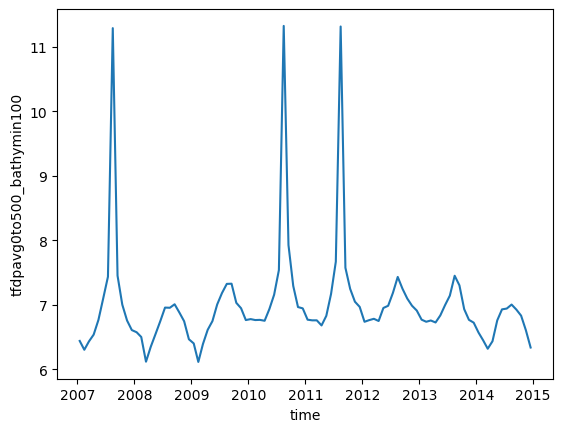

In [48]:
qdm_result.tfdpavg0to500_bathymin100.plot()

Okay, this gave us actual output, which is way farther along than we managed in our previous use of cmethods.  Let's plot against the "obs" and "sim" series:

/var/folders/lm/d_79zh011jddr2c41jsw0dvr0000gq/T/ipykernel_67061/2304752419.py:3: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  ax.plot(test_series.indexes['time'].to_datetimeindex().values, test_series, label='CESM2')


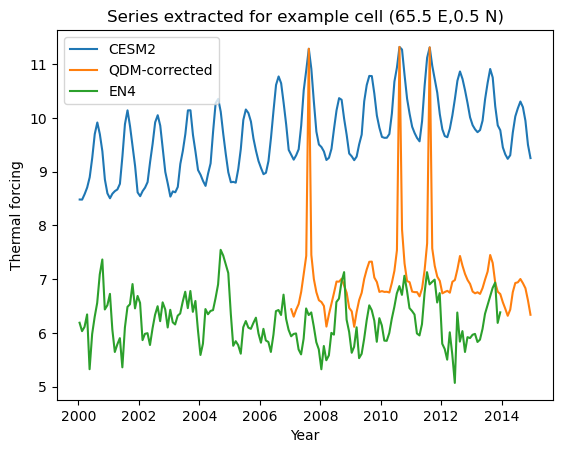

In [57]:
fig, ax = plt.subplots()
# ax.plot(test_series.time.values, test_series)
ax.plot(test_series.indexes['time'].to_datetimeindex().values, test_series, label='CESM2')
ax.plot(qdm_result.time, qdm_result.tfdpavg0to500_bathymin100.values, label='QDM-corrected')
ax.plot(tobs_times,
    test_obs_trimmed, label='EN4')
ax.legend(loc='best')
ax.set(xlabel='Year', ylabel='Thermal forcing', title='Series extracted for example cell ({} E,{} N)'.format(lat_sel, lon_sel))
plt.show()

And now perhaps with the 3D test data? (note that in both of these cases, I'm running cells up here after already running through everything below to create the pre-processed datasets)

In [50]:
qdm_result_3d = apply_cmfunc(
    method = "quantile_delta_mapping",
    obs = tobs_ds.sel(time=slice('2000','2007')),
    simh = test_ds.sel(time=slice('2000', '2007')).rename({'time':'t_simh'}),
    simp = test_ds.sel(time=slice('2007', '2014')),
    n_quantiles = 100,
    input_core_dims={"obs": "time", "simh": "t_simh", "simp": "time"},
    # group={"obs": "time.month", "simh": "t_simh.month", "simp": "time"},
    kind = "+", # to calculate the relative rather than the absolute change, "*" can be used instead of "+" (this is prefered when adjusting precipitation)
)

In [55]:
test_ds

<xarray.Dataset> Size: 7kB
Dimensions:                    (lat: 4, lon: 1, time: 180)
Coordinates:
  * lat                        (lat) float64 32B 64.5 65.5 66.5 67.5
  * lon                        (lon) float64 8B 1.5
  * time                       (time) datetime64[ns] 1kB 2000-01-15T12:00:00 ...
Data variables:
    tfdpavg0to500_bathymin100  (time, lat, lon) float64 6kB 9.329 8.606 ... 8.2

In [59]:
qdm_result_3d

<xarray.Dataset> Size: 4kB
Dimensions:                    (lat: 4, lon: 1, time: 96)
Coordinates:
  * lat                        (lat) float32 16B 64.5 65.5 66.5 67.5
  * lon                        (lon) float32 4B 1.5
  * time                       (time) datetime64[ns] 768B 2007-01-15T12:00:00...
Data variables:
    tfdpavg0to500_bathymin100  (time, lat, lon) float64 3kB 6.828 ... 6.732

---

Initial run settings from Vincent.  Replace most of this with our own file selection, eventually.  Just check that this works.

In [7]:
DepthRange         = [0,500]
ShallowThreshold   = 100
PeriodObs0         = [1950,2015]
SigmaExclusion     = 4 #number of sdevs beyond which we constrain values in QDM
yrWindowProj       = 30 #number of years running window CDF in projection period 

# DirEN4         = f'{cwd}Verjans_InputOutput/'
# EN4file        = f'dpavg_tf_EN4anl_Dp{DepthRange[0]}to{DepthRange[1]}_bathymin{ShallowThreshold}.nc'
DirEN4         = f'/Users/eultee/Library/CloudStorage/OneDrive-NASA/Documents/ISMIP7/Verjans-process/'
EN4file        = f'dpavg_tf_EN4anl_Dp{DepthRange[0]}to{DepthRange[1]}_bathymin{ShallowThreshold}.nc'

In [8]:
## Load EN4 using xarray
ds = xr.open_dataset(DirEN4+EN4file, decode_times='timeDim')
ds2 = ds.assign_coords({'timeDim': ds.time, 
                  'latDim': ds.lat, 
                  'lonDim': ds.lon,
                  'depthDim': ds.depth})
ds2

tfEN4 = ds2.tfdpavg0to500_bathymin100.rename({'timeDim': 'time',
                                              'latDim': 'lat',
                                              'lonDim': 'lon'})
tfEN4

<xarray.DataArray 'tfdpavg0to500_bathymin100' (time: 1465, lat: 27, lon: 80)> Size: 13MB
[3164400 values with dtype=float32]
Coordinates:
  * time     (time) float32 6kB 1.9e+03 1.9e+03 1.9e+03 ... 2.022e+03 2.022e+03
  * lat      (lat) float32 108B 59.0 60.0 61.0 62.0 63.0 ... 82.0 83.0 84.0 85.0
  * lon      (lon) float32 320B 1.0 282.0 283.0 284.0 ... 358.0 359.0 360.0

In [9]:
# import pandas as pd
## Bryan Riel, please save me. Decimal year to datetime is the bane of this notebook.
## pasting stuff from iceutils below.
#-*- coding: utf-8 -*-

def tdec2datestr(tdec_in, returndate=False):
    """
    Convert a decimaly year to an iso date string.
    """
    if isinstance(tdec_in, (list, np.ndarray)):
        tdec_list = copy.deepcopy(tdec_in)
    else:
        tdec_list = [tdec_in]
    current_list = []
    for tdec in tdec_list:
        year = int(tdec)
        yearStart = datetime.datetime(year, 1, 1)
        if year % 4 == 0:
            ndays_in_year = 366.0
        else:
            ndays_in_year = 365.0
        days = (tdec - year) * ndays_in_year
        seconds = (days - int(days)) * 86400
        tdelta = datetime.timedelta(days=int(days), seconds=int(seconds))
        current = yearStart + tdelta
        if not returndate:
            current = current.isoformat(' ').split()[0]
        current_list.append(current)

    if len(current_list) == 1:
        return current_list[0]
    else:
        return np.array(current_list)

time_arr = tdec2datestr(tfEN4.time.values)
time_arr

array(['1900-01-15', '1900-02-14', '1900-03-15', ..., '2021-11-14',
       '2021-12-15', '2022-01-14'], shape=(1465,), dtype='<U10')

Okay, finally successfully converted.  We need the obs dataset to have the same time type as the modeled one in order to use QDM `adjust`.

---

Now we try the cmethods Quantile Delta Mapping.  See [example notebook](https://github.com/ehultee/gris-iceocean-process/blob/main/python-cmethods_examples.ipynb) added by DF.

QDM `adjust` from cmethods needs datasets defined and input as simulated historical (`simh`), simulated projection (`simp`), and observed historical against which to bias-correct (`obs`).

Slice the EN4 dataset for the obs period defined by Vincent's `PeriodObs0`.  Import the example dataset of CESM2 TF for the same depth range and bathymetric threshold.

In [10]:
ds3 = xr.open_dataset(DirEN4+'/tfdpavg-CESM2-2024-11-14.nc')
ds3

<xarray.Dataset> Size: 4MB
Dimensions:  (time: 180, lat: 29, lon: 90)
Coordinates:
  * time     (time) object 1kB 2000-01-15 12:00:00 ... 2014-12-15 12:00:00
  * lat      (lat) float64 232B 57.5 58.5 59.5 60.5 61.5 ... 82.5 83.5 84.5 85.5
  * lon      (lon) float64 720B 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
Data variables:
    TF       (time, lat, lon) float64 4MB ...

This is a short example dataset.  For the sake of argument, let's take a very short correction period over the first half, and use the second half as the projection.  Let's try at a single grid cell to get our bearings.

---
### Try QDM on a 1D series

In [11]:
## select a single site
lat_sel = 65.5 ## deg N
lon_sel = 0.5 ## deg E

test_series = ds3.TF.sel(lon=lon_sel, lat=lat_sel, method='nearest')

test_series

<xarray.DataArray 'TF' (time: 180)> Size: 1kB
[180 values with dtype=float64]
Coordinates:
  * time     (time) object 1kB 2000-01-15 12:00:00 ... 2014-12-15 12:00:00
    lat      float64 8B 65.5
    lon      float64 8B 0.5

In [12]:
test_obs = tfEN4.sel(lat=lat_sel, lon=lon_sel, method='nearest')
test_obs_trimmed = test_obs.sel(time=slice('2000', '2014'))
test_obs_trimmed

<xarray.DataArray 'tfdpavg0to500_bathymin100' (time: 168)> Size: 672B
[168 values with dtype=float32]
Coordinates:
  * time     (time) float32 672B 2e+03 2e+03 2e+03 ... 2.014e+03 2.014e+03
    lat      float32 4B 66.0
    lon      float32 4B 1.0

In order to plot these series together, we need both to have a date type matplotlib recognizes. You would think it would be enough to convert one of them (EN4) but now the other is not behaving, so here we are.  Importing the inverse function from [Bryan Riel](https://github.com/bryanvriel/iceutils/blob/master/iceutils/timeutils.py).

In [13]:
def datestr2tdec(yy=0, mm=0, dd=0, hour=0, minute=0, sec=0, microsec=0, dateobj=None):
    """
    Convert year, month, day, hours, minutes, seconds to decimal year.
    """
    if dateobj is not None:
        if type(dateobj) == str:
            yy, mm, dd = [int(val) for val in dateobj.split('-')]
            hour, minute, sec = [0, 0, 0]
        elif type(dateobj) == datetime.datetime:
            attrs = ['year', 'month', 'day', 'hour', 'minute', 'second']
            yy, mm, dd, hour, minute, sec = [getattr(dateobj, attr) for attr in attrs]
        elif type(dateobj) == np.datetime64:
            yy = dateobj.astype('datetime64[Y]').astype(int) + 1970
            mm = dateobj.astype('datetime64[M]').astype(int) % 12 + 1
            days = (
                (dateobj - dateobj.astype('datetime64[M]')) / np.timedelta64(1, 'D')
            )
            dd = int(days) + 1
            hour, minute, sec = [0, 0, 0]
        else:
            raise NotImplementedError('dateobj must be str, datetime, or np.datetime64.')

    # Make datetime object for start of year
    yearStart = datetime.datetime(yy, 1, 1, 0, 0, 0)
    # Make datetime object for input time
    current = datetime.datetime(yy, mm, dd, hour, minute, sec, microsec)
    # Compute number of days elapsed since start of year
    tdelta = current - yearStart
    # Convert to decimal year and account for leap year
    if yy % 4 == 0:
        return float(yy) + tdelta.total_seconds() / (366.0 * 86400)
    else:
        return float(yy) + tdelta.total_seconds() / (365.0 * 86400)

In [14]:
## should we try expressing both with to_datetimeindex...?
# test_obs_trimmed.indexes['time'].to_datetimeindex()
tobs_times = pd.to_datetime(tdec2datestr(test_obs_trimmed.time.values))

/var/folders/lm/d_79zh011jddr2c41jsw0dvr0000gq/T/ipykernel_67061/1914164298.py:3: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  ax.plot(test_series.indexes['time'].to_datetimeindex().values, test_series, label='CESM2')


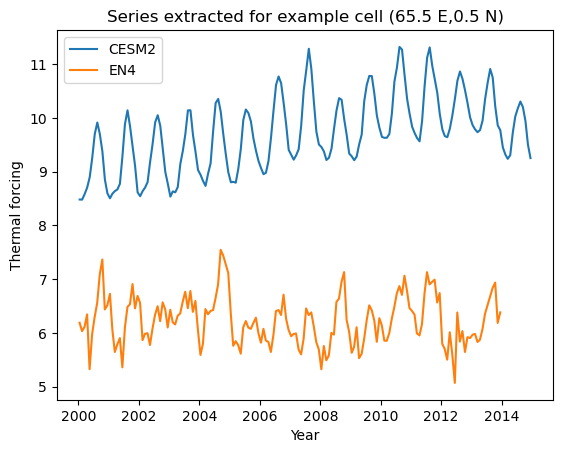

In [15]:
fig, ax = plt.subplots()
# ax.plot(test_series.time.values, test_series)
ax.plot(test_series.indexes['time'].to_datetimeindex().values, test_series, label='CESM2')
ax.plot(tobs_times,
    test_obs_trimmed, label='EN4')
ax.legend(loc='best')
ax.set(xlabel='Year', ylabel='Thermal forcing', title='Series extracted for example cell ({} E,{} N)'.format(lat_sel, lon_sel))
plt.show()

In [16]:
obs_series = test_obs_trimmed.assign_coords(new_time = ('time', tobs_times))
obs_series = obs_series.drop_indexes('time')
obs_series_1 = obs_series.set_xindex('new_time').drop_vars('time')
obs_series_1 = obs_series_1.rename({'new_time': 'time'})
obs_series_1

/var/folders/lm/d_79zh011jddr2c41jsw0dvr0000gq/T/ipykernel_67061/786067489.py:4: UserWarning: rename 'new_time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  obs_series_1 = obs_series_1.rename({'new_time': 'time'})


<xarray.DataArray 'tfdpavg0to500_bathymin100' (time: 168)> Size: 672B
array([6.188295, 6.031511, 6.111092, 6.342698, 5.322858, 5.977356, 6.292001,
       6.557708, 7.087722, 7.365596, 6.435105, 6.51431 , 6.72559 , 6.062102,
       5.643488, 5.784337, 5.901501, 5.357799, 6.100777, 6.483984, 6.532448,
       6.908222, 6.455432, 6.686839, 6.557996, 5.864292, 5.981475, 5.993785,
       5.773354, 6.084009, 6.333822, 6.495696, 6.217615, 6.567864, 6.435992,
       6.099918, 6.429314, 6.19588 , 6.156298, 6.318989, 6.360559, 6.58206 ,
       6.765553, 6.459953, 6.778625, 6.390534, 6.593271, 6.059785, 5.588201,
       5.798462, 6.442698, 6.346113, 6.406845, 6.423607, 6.64341 , 6.901817,
       7.545504, 7.438795, 7.277249, 7.113552, 6.348721, 5.759008, 5.844891,
       5.77152 , 5.611696, 6.10309 , 6.219512, 6.096506, 6.074378, 6.18551 ,
       6.2821  , 5.989189, 5.816474, 6.074712, 5.858047, 5.829924, 5.644062,
       5.964849, 6.40362 , 6.425118, 6.332376, 6.710835, 6.260806, 6.055998,
       5.936271, 5.979176, 5.989061, 5.690672, 5.59883 , 5.893238, 6.454457,
       6.331352, 6.380164, 6.123486, 5.826003, 5.693282, 5.321788, 5.754853,
       5.489316, 5.581059, 5.999027, 5.966858, 6.573681, 6.637467, 6.950558,
       7.12994 , 6.246004, 6.016577, 5.628737, 5.740726, 6.103446, 5.528854,
       5.609381, 5.886396, 6.234245, 6.512042, 6.421648, 6.226967, 5.833534,
       6.273051, 6.138304, 5.855212, 5.850976, 5.995903, 6.260265, 6.481952,
       6.732891, 6.870107, 6.706784, 7.062644, 6.784534, 6.460699, 6.406393,
       6.340259, 5.988848, 5.951675, 6.159991, 6.735094, 7.129336, 6.901795,
       6.948931, 6.990232, 6.564746, 6.739103, 5.79705 , 5.69866 , 5.501083,
       6.010116, 5.603032, 5.067644, 6.378194, 5.836841, 6.032781, 5.644087,
       5.919816, 5.902743, 5.96468 , 5.980541, 5.829802, 5.87288 , 6.074504,
       6.35464 , 6.515546, 6.675539, 6.835655, 6.935742, 6.185145, 6.381448],
      dtype=float32)
Coordinates:
    lat      float32 4B 66.0
    lon      float32 4B 1.0
  * time     (time) datetime64[ns] 1kB 2000-01-14 2000-02-13 ... 2013-12-15

In [17]:
sim_series = test_series.assign_coords(new_time = ('time', test_series.indexes['time'].to_datetimeindex().values))
sim_series = sim_series.drop_indexes('time')
sim_series_1 = sim_series.set_xindex('new_time').drop_vars('time')
sim_series_1 = sim_series_1.rename({'new_time': 'time'})
sim_series_1 
## = sim_series_1.sel(time=slice('2000','2013')) ## maybe the underlying data has to be exactly the same length? alignment otherwise seems good...

/var/folders/lm/d_79zh011jddr2c41jsw0dvr0000gq/T/ipykernel_67061/2873268519.py:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  sim_series = test_series.assign_coords(new_time = ('time', test_series.indexes['time'].to_datetimeindex().values))
/var/folders/lm/d_79zh011jddr2c41jsw0dvr0000gq/T/ipykernel_67061/2873268519.py:4: UserWarning: rename 'new_time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  sim_series_1 = sim_series_1.rename({'new_time': 'time'})


<xarray.DataArray 'TF' (time: 180)> Size: 1kB
array([ 8.482153,  8.480402,  8.583622,  8.706512,  8.897158,  9.257291,
        9.700129,  9.916054,  9.698217,  9.380015,  8.854247,  8.596809,
        8.505132,  8.590588,  8.638183,  8.669328,  8.774258,  9.288634,
        9.885701, 10.142702,  9.843756,  9.471511,  9.105198,  8.614661,
        8.543751,  8.638717,  8.703588,  8.806441,  9.182708,  9.520937,
        9.919073, 10.051385,  9.856791,  9.428005,  8.995588,  8.774898,
        8.536255,  8.633107,  8.616372,  8.716689,  9.143955,  9.38787 ,
        9.702791, 10.141904, 10.143293,  9.683821,  9.370972,  9.031488,
        8.941387,  8.827749,  8.735757,  8.96335 ,  9.15533 ,  9.752679,
       10.277973, 10.355333, 10.116285,  9.702312,  9.327933,  8.988849,
        8.803785,  8.810685,  8.795574,  9.050997,  9.422383,  9.963602,
       10.157968, 10.091823,  9.933307,  9.616913,  9.389752,  9.198501,
        9.065573,  8.953725,  8.980232,  9.198465,  9.634092, 10.139313,
       10.615456, 10.773114, 10.646695, 10.277054,  9.876913,  9.405155,
        9.312575,  9.224012,  9.304195,  9.417862,  9.859957, 10.515943,
       10.888691, 11.288455, 10.913834, 10.303497,  9.745391,  9.505793,
        9.458249,  9.376703,  9.218145,  9.258927,  9.426802,  9.798283,
       10.142315, 10.369083, 10.338715,  9.983553,  9.685887,  9.338455,
        9.285326,  9.21464 ,  9.281154,  9.509786,  9.690856, 10.309841,
       10.613094, 10.78307 , 10.78007 , 10.452453, 10.04482 ,  9.818765,
        9.647572,  9.630586,  9.632079,  9.701928, 10.084488, 10.676864,
       10.939874, 11.32293 , 11.273678, 10.80194 , 10.360643, 10.078525,
        9.836506,  9.720462,  9.62825 ,  9.565149,  9.94418 , 10.598351,
       11.122961, 11.313997, 10.974769, 10.726183, 10.469265, 10.071289,
        9.787869,  9.663154,  9.642299,  9.80198 , 10.048581, 10.35515 ,
       10.693599, 10.865697, 10.727121, 10.515832, 10.276035, 10.012108,
        9.865239,  9.788423,  9.735667,  9.775006,  9.950734, 10.350857,
       10.652682, 10.912284, 10.754039, 10.216868,  9.861831,  9.771551,
        9.452876,  9.322526,  9.239674,  9.307775,  9.725534, 10.028962,
       10.179177, 10.306056, 10.201875,  9.946986,  9.502718,  9.253404])
Coordinates:
    lat      float64 8B 65.5
    lon      float64 8B 0.5
  * time     (time) datetime64[ns] 1kB 2000-01-15T12:00:00 ... 2014-12-15T12:...

In [18]:
obs_ds = obs_series_1.to_dataset()
sim_ds = sim_series_1.to_dataset()

In [19]:
sim_ds = sim_ds.rename({'TF': 'tfdpavg0to500_bathymin100'})

In [20]:
## let's try QDM adjustment here
# to adjust a 3d dataset
qdm_result = adjust(
    method = "quantile_delta_mapping",
    obs = obs_ds.sel(time=slice('2000','2007')),
    simh = sim_ds.sel(time=slice('2000', '2007')).rename({'time':'t_simh'}),
    simp = sim_ds.sel(time=slice('2007', '2014')),
    n_quantiles = 100,
    input_core_dims={"obs": "time", "simh": "t_simh", "simp": "time"},
    # group={"obs": "time.month", "simh": "t_simh.month", "simp": "time"},
    kind = "+", # to calculate the relative rather than the absolute change, "*" can be used instead of "+" (this is prefered when adjusting precipitation)
)

AttributeError: 'Dataset' object has no attribute 'to_dataset'

---
## Test QDM on a 3D dataset instead of a series
We are getting 
```
AttributeError: 'Dataset' object has no attribute 'to_dataset'
```

Perhaps this is because we've fed the function a series converted to a Dataset, rather than a 3D dataset?  Take a small slice to try.

### Process a small subset of simulated data

In [21]:
## try to do all the steps in pre-processing at once...
test_ds = ds3.TF.sel(lon=slice(lon_sel+0.1, lon_sel+1), lat=slice(lat_sel-1, lat_sel+2))
test_ds

<xarray.DataArray 'TF' (time: 180, lat: 4, lon: 1)> Size: 6kB
[720 values with dtype=float64]
Coordinates:
  * time     (time) object 1kB 2000-01-15 12:00:00 ... 2014-12-15 12:00:00
  * lat      (lat) float64 32B 64.5 65.5 66.5 67.5
  * lon      (lon) float64 8B 1.5

In [22]:
## aligning the time indices
test_ds = test_ds.assign_coords(new_time = ('time', test_ds.indexes['time'].to_datetimeindex().values))
test_ds = test_ds.drop_indexes('time')
test_ds = test_ds.set_xindex('new_time').drop_vars('time')

## aligning the names of the variables between obs and sim
test_ds = test_ds.to_dataset()
test_ds = test_ds.rename({'new_time': 'time', 'TF': 'tfdpavg0to500_bathymin100'})
test_ds

/var/folders/lm/d_79zh011jddr2c41jsw0dvr0000gq/T/ipykernel_67061/3224100055.py:2: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  test_ds = test_ds.assign_coords(new_time = ('time', test_ds.indexes['time'].to_datetimeindex().values))
/var/folders/lm/d_79zh011jddr2c41jsw0dvr0000gq/T/ipykernel_67061/3224100055.py:8: UserWarning: rename 'new_time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  test_ds = test_ds.rename({'new_time': 'time', 'TF': 'tfdpavg0to500_bathymin100'})


<xarray.Dataset> Size: 7kB
Dimensions:                    (lat: 4, lon: 1, time: 180)
Coordinates:
  * lat                        (lat) float64 32B 64.5 65.5 66.5 67.5
  * lon                        (lon) float64 8B 1.5
  * time                       (time) datetime64[ns] 1kB 2000-01-15T12:00:00 ...
Data variables:
    tfdpavg0to500_bathymin100  (time, lat, lon) float64 6kB ...

### Process small subset of reanalysis data

In [23]:
tobs_ds = tfEN4.sel(lon=slice(lon_sel-1, lon_sel+1), 
                    lat=slice(lat_sel-2, lat_sel+2), 
                    time=slice('2000', '2014'))
tobs_ds

<xarray.DataArray 'tfdpavg0to500_bathymin100' (time: 168, lat: 4, lon: 1)> Size: 3kB
[672 values with dtype=float32]
Coordinates:
  * time     (time) float32 672B 2e+03 2e+03 2e+03 ... 2.014e+03 2.014e+03
  * lat      (lat) float32 16B 64.0 65.0 66.0 67.0
  * lon      (lon) float32 4B 1.0

We are back to the problem of offset grids.  Ideally we would do a point-by-point implementation that uses nearest neighbors, because xarray is good at this.  Realigning the whole grid is less efficient.  For now, let's see if it will work to just force the same grid -- this tells us whether the problem is even worth solving for cmethods implementation.

In [24]:
scam_lat = [v+0.5 for v in tobs_ds.lat.values]
scam_lon = [v+0.5 for v in tobs_ds.lon.values]

In [25]:
## overwrite them
tobs_ds = tobs_ds.assign_coords(new_lat = ('lat', scam_lat))
tobs_ds = tobs_ds.drop_indexes('lat')
tobs_ds = tobs_ds.set_xindex('new_lat').drop_vars('lat')

tobs_ds = tobs_ds.assign_coords(new_lon = ('lon', scam_lon))
tobs_ds = tobs_ds.drop_indexes('lon')
tobs_ds = tobs_ds.set_xindex('new_lon').drop_vars('lon')

tobs_ds = tobs_ds.rename({'new_lat': 'lat', 'new_lon': 'lon'})

/var/folders/lm/d_79zh011jddr2c41jsw0dvr0000gq/T/ipykernel_67061/3190631367.py:10: UserWarning: rename 'new_lat' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  tobs_ds = tobs_ds.rename({'new_lat': 'lat', 'new_lon': 'lon'})
/var/folders/lm/d_79zh011jddr2c41jsw0dvr0000gq/T/ipykernel_67061/3190631367.py:10: UserWarning: rename 'new_lon' to 'lon' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  tobs_ds = tobs_ds.rename({'new_lat': 'lat', 'new_lon': 'lon'})


In [26]:
tobs_ds

<xarray.DataArray 'tfdpavg0to500_bathymin100' (time: 168, lat: 4, lon: 1)> Size: 3kB
[672 values with dtype=float32]
Coordinates:
  * time     (time) float32 672B 2e+03 2e+03 2e+03 ... 2.014e+03 2.014e+03
  * lat      (lat) float32 16B 64.5 65.5 66.5 67.5
  * lon      (lon) float32 4B 1.5

Reset the time index to be a datetime type.  Note that these data are also float32 rather than float64.  Could cause problems?

In [27]:
tobs_ds = tobs_ds.assign_coords(new_time = ('time', pd.to_datetime(tdec2datestr(tobs_ds.time.values))))
tobs_ds = tobs_ds.drop_indexes('time')
tobs_ds = tobs_ds.set_xindex('new_time').drop_vars('time')
tobs_ds = tobs_ds.rename({'new_time': 'time'})
tobs_ds

/var/folders/lm/d_79zh011jddr2c41jsw0dvr0000gq/T/ipykernel_67061/2993052384.py:4: UserWarning: rename 'new_time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  tobs_ds = tobs_ds.rename({'new_time': 'time'})


<xarray.DataArray 'tfdpavg0to500_bathymin100' (time: 168, lat: 4, lon: 1)> Size: 3kB
[672 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 16B 64.5 65.5 66.5 67.5
  * lon      (lon) float32 4B 1.5
  * time     (time) datetime64[ns] 1kB 2000-01-14 2000-02-13 ... 2013-12-15

### Attempt QDM on these 3D sets

In [28]:
qdm_result = adjust(
    method = "quantile_delta_mapping",
    obs = tobs_ds.sel(time=slice('2000','2007')),
    simh = test_ds.sel(time=slice('2000', '2007')).rename({'time':'t_simh'}),
    simp = test_ds.sel(time=slice('2007', '2014')),
    n_quantiles = 100,
    input_core_dims={"obs": "time", "simh": "t_simh", "simp": "time"},
    # group={"obs": "time.month", "simh": "t_simh.month", "simp": "time"},
    kind = "+", # to calculate the relative rather than the absolute change, "*" can be used instead of "+" (this is prefered when adjusting precipitation)
)

AttributeError: 'Dataset' object has no attribute 'to_dataset'

The source code warns that this is disabled (??), and the line is only called if the group argument is not set.  So, fun-lovers that we are, we try to use a grouping suggested in the cmethods docs:

In [29]:
qdm_result = adjust(
    method = "quantile_delta_mapping",
    obs = tobs_ds.sel(time=slice('2000','2007')),
    simh = test_ds.sel(time=slice('2000', '2007')).rename({'time':'t_simh'}),
    simp = test_ds.sel(time=slice('2007', '2014')),
    n_quantiles = 100,
    input_core_dims={"obs": "time", "simh": "t_simh", "simp": "time"},
    group={"obs": "time.month", "simh": "t_simh.month", "simp": "time"},
    kind = "+", # to calculate the relative rather than the absolute change, "*" can be used instead of "+" (this is prefered when adjusting precipitation)
)

ValueError: Can't use group for distribution based methods.

...but we can't use group for distribution-based methods.  Alas.